In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from langdetect import detect
import time
import multiprocessing
from threading import Thread
import codecs
import re
import itertools

In [2]:
create_all_lyrics2 = False
try:
    fh = open("data/all_lyrics2.csv", 'r')
except FileNotFoundError:
    create_all_lyrics2 = True

In [3]:
if(create_all_lyrics2):
    with codecs.open('data/all_lyrics.csv', 'r', encoding='utf-8', errors='replace') as fdata:
        data = fdata.read()
        f= open("data/all_lyrics2.csv","w",  encoding='utf-8')
        f.write(data)
        f.close()

In [4]:
df_all_lyrics  = pd.read_csv('data/all_lyrics2.csv', encoding='utf8')  
df_all_lyrics.drop(columns=["Unnamed: 0"],inplace=True)
df_all_lyrics.dropna(subset=["Lyric"], inplace = True)
df_all_lyrics["Language"].fillna("Desconhecido", inplace=True)
df_all_lyrics = df_all_lyrics[(df_all_lyrics["Language"] == "Desconhecido") | (df_all_lyrics["Language"] == "bra")]
df_all_lyrics = df_all_lyrics[df_all_lyrics["Lyric"] != "Instrumental"]
df_all_lyrics['row_number'] = df_all_lyrics.groupby(['LyricLink']).cumcount() + 1
df_all_lyrics = df_all_lyrics[df_all_lyrics['row_number']==1].drop(columns = ['row_number'])
df_all_lyrics.reset_index(inplace=True, drop = True)

In [5]:
def lang_detector(x): 
    detected = 'Desconhecido'
    try:
        detected = detect(x)
    finally:
        return detected

num_cores =  multiprocessing.cpu_count()
df_all_lyrics_splitted = np.array_split(df_all_lyrics, num_cores)

df_all_lyrics_partition_result_dictionary = {}

def compute(id_thread):
    df_all_lyrics_partition = df_all_lyrics_splitted[id_thread]
    print ('thread '+str(id_thread)+' started')
    df_all_lyrics_partition["LanguageDetected"] = df_all_lyrics_partition["Lyric"].map(lang_detector)
    df_all_lyrics_partition_result_dictionary[id_thread] = df_all_lyrics_partition
    print ('thread '+str(id_thread)+' finished')
    
# Paralelizando 
start = time.time()
threads = [Thread(target=compute,args=(id_thread,)) for id_thread in range(num_cores)]
[thread.start() for thread in threads]
[thread.join() for thread in threads]   
end = time.time()

partitions = []
for i in range(num_cores):
    partitions.append(df_all_lyrics_partition_result_dictionary[i])

df_all_lyrics = pd.concat(partitions, ignore_index=True)

print('\nTime(s): '+str("%.2f" % (end - start))+'s\n')

thread 0 started
thread 1 started
thread 2 started
thread 3 started
thread 1 finished
thread 2 finished
thread 3 finished
thread 0 finished

Time(s): 709.02s



In [6]:
df_all_lyrics = df_all_lyrics[df_all_lyrics["LanguageDetected"] == "pt"]
df_all_lyrics.reset_index(inplace=True, drop = True)

In [7]:
def proccess_lyric(lyric):
    try:
        regex = '\[.*?\]'
        lyric = re.sub(regex,'',lyric)
        regex = '\(.*?\)'
        lyric = re.sub(regex,'',lyric)
    finally:
        return lyric

df_all_lyrics["Lyric"] = df_all_lyrics["Lyric"].map(proccess_lyric)

In [8]:
df_all_lyrics[:5]

,Lyric,Language,LyricLink,LanguageDetected
0,. Minha princesa eu troco tudo pra estar conti...,Desconhecido,/andre-drake/bae-ft-v-p-rap.html,pt
1,". Mais views, pode ser?. Cê sabe, que só tem u...",Desconhecido,/andre-drake/by-chance-brazilian-remix.html,pt
2,"4 Paredes uma jaula, na minha mão uma faca. Um...",Desconhecido,/andre-drake/casa-do-terror.html,pt
3,". Na ""madruga"" não consigo dormir. muito barul...",Desconhecido,/andre-drake/na-madrugada.html,pt
4,. Vp de novo que convida. Dessa vez segunda pa...,Desconhecido,/andre-drake/v-p-convida-parte-2.html,pt


In [14]:
df_all_songs_links = pd.read_csv('data/all_songs_links.csv', encoding='utf8')   
df_all_songs_links.drop(columns=["Unnamed: 0"],inplace=True)
df_all_songs_links['row_number'] = df_all_songs_links.groupby(['SLink']).cumcount() + 1
df_all_songs_links = df_all_songs_links[df_all_songs_links['row_number']==1].drop(columns = ['row_number'])
df_all_songs_links.reset_index(inplace=True, drop = True)

In [16]:
df_all_songs_links[:5]

,ALink,SName,SLink
0,/50-cent/,In da Club,/50-cent/in-da-club.html
1,/50-cent/,Candy Shop,/50-cent/candy-shop.html
2,/50-cent/,21 Questions,/50-cent/21-questions.html
3,/50-cent/,P.I.M.P.,/50-cent/p-i-m-p.html
4,/50-cent/,Window Shopper,/50-cent/window-shopper.html


In [17]:
df_lyrics = df_all_songs_links.merge(df_all_lyrics, left_on='SLink', right_on='LyricLink')
df_lyrics.drop(columns=["LyricLink","LanguageDetected","Language"],inplace=True)
df_lyrics[:5]

,ALink,SName,SLink,Lyric
0,/andre-drake/,Bae ft. V.P Rap,/andre-drake/bae-ft-v-p-rap.html,. Minha princesa eu troco tudo pra estar conti...
1,/andre-drake/,By Chance (Brazilian Remix),/andre-drake/by-chance-brazilian-remix.html,". Mais views, pode ser?. Cê sabe, que só tem u..."
2,/andre-drake/,Casa do Terror,/andre-drake/casa-do-terror.html,"4 Paredes uma jaula, na minha mão uma faca. Um..."
3,/andre-drake/,Na Madrugada,/andre-drake/na-madrugada.html,". Na ""madruga"" não consigo dormir. muito barul..."
4,/andre-drake/,V.P Convida Parte 2,/andre-drake/v-p-convida-parte-2.html,. Vp de novo que convida. Dessa vez segunda pa...


In [18]:
df_artists = pd.read_csv('data/artists-data.csv', encoding='utf8')   
df_artists.drop(columns=["Artist","Songs","Popularity"],inplace=True)

def genres_map(genres_str):
    genres = [y.strip() for y in genres_str.split(";")]
    if("COLETÂNEA" in genres):
        genres.remove("COLETÂNEA")
    return genres

df_artists = df_artists[~df_artists["Genres"].isnull()]

df_artists["Genres"] = df_artists["Genres"].map(genres_map)

df_artists[:5]

,ParentGenre,Genres,Link
0,Hip Hop,"[Hip Hop, Rap, Black Music]",/50-cent/
1,Black Music,"[Black Music, R&B, Hip Hop]",/aaliyah/
2,Black Music,"[Black Music, Rap, Hip Hop]",/ace-hood/
3,Rap,"[Rap, Black Music, Pop]",/akon/
4,Black Music,"[Black Music, Soul Music, R&B]",/alicia-keys/


In [19]:
df_lyrics = df_lyrics.merge(df_artists, left_on='ALink', right_on='Link')
df_lyrics.drop(columns=["Link"],inplace=True)

In [23]:
df_lyrics[['Lyric','ParentGenre','Genres']]

,Lyric,ParentGenre,Genres
0,. Minha princesa eu troco tudo pra estar conti...,Black Music,"[Black Music, Hip Hop, Rap]"
1,". Mais views, pode ser?. Cê sabe, que só tem u...",Black Music,"[Black Music, Hip Hop, Rap]"
2,"4 Paredes uma jaula, na minha mão uma faca. Um...",Black Music,"[Black Music, Hip Hop, Rap]"
3,". Na ""madruga"" não consigo dormir. muito barul...",Black Music,"[Black Music, Hip Hop, Rap]"
4,. Vp de novo que convida. Dessa vez segunda pa...,Black Music,"[Black Music, Hip Hop, Rap]"
5,. Meu mano seu tiro de 12. não é páreo pra par...,Black Music,"[Black Music, Hip Hop, Rap]"
6,"A história se iniciou em 1977, com uma bela mo...",Hip Hop,"[Hip Hop, Rap, Gospel/Religioso]"
7,E só agora. O homem chora. E quando o homem ch...,Hip Hop,"[Hip Hop, Rap, Gospel/Religioso]"
8,"Gemidos numa noite de domingo, madrugada. Lágr...",Hip Hop,"[Hip Hop, Rap, Gospel/Religioso]"
9,Num certo dia nebuloso um pouco chuvoso e frio...,Hip Hop,"[Hip Hop, Rap, Gospel/Religioso]"


In [24]:
df_lyrics[:5]

,ALink,SName,SLink,Lyric,ParentGenre,Genres
0,/andre-drake/,Bae ft. V.P Rap,/andre-drake/bae-ft-v-p-rap.html,. Minha princesa eu troco tudo pra estar conti...,Black Music,"[Black Music, Hip Hop, Rap]"
1,/andre-drake/,By Chance (Brazilian Remix),/andre-drake/by-chance-brazilian-remix.html,". Mais views, pode ser?. Cê sabe, que só tem u...",Black Music,"[Black Music, Hip Hop, Rap]"
2,/andre-drake/,Casa do Terror,/andre-drake/casa-do-terror.html,"4 Paredes uma jaula, na minha mão uma faca. Um...",Black Music,"[Black Music, Hip Hop, Rap]"
3,/andre-drake/,Na Madrugada,/andre-drake/na-madrugada.html,". Na ""madruga"" não consigo dormir. muito barul...",Black Music,"[Black Music, Hip Hop, Rap]"
4,/andre-drake/,V.P Convida Parte 2,/andre-drake/v-p-convida-parte-2.html,. Vp de novo que convida. Dessa vez segunda pa...,Black Music,"[Black Music, Hip Hop, Rap]"


In [25]:
df_lyrics["ParentGenre"].value_counts()

Sertanejo           19850
Forró               10760
Gospel/Religioso    10738
Funk Carioca         4266
Pop/Rock             3159
Rap                  2874
Romântico            2612
Regional             2585
Rock                 2335
Bossa Nova           2129
MPB                  2085
Reggae               2030
Velha Guarda         1874
Trilha Sonora        1056
Infantil              925
Punk Rock             690
Fado                  685
Pop                   562
Samba                 423
Dance                 411
Soul Music            387
World Music           316
Country               299
Black Music           288
Hip Hop               234
Indie                 232
Axé                   213
Rock Alternativo      177
Jazz                  163
Folk                  154
Surf Music            154
Electronica           135
Emocore               130
Blues                 113
Funk                  109
Psicodelia             92
Hardcore               85
R&B                    83
Clássico    

In [27]:
genres = {}
for i in df_lyrics.index:
    genres_arr = df_lyrics["Genres"][i]
    for genre in genres_arr:
        genres[genre] = ''
genres = list(genres.keys())

In [28]:
df_or = pd.DataFrame(columns=genres, index =genres).fillna(0)
df_and = pd.DataFrame(columns=genres, index =genres).fillna(0)

In [29]:
def process(genres_arr):
    global df_or
    df = pd.DataFrame(columns=genres, index =genres).fillna(0)
    for genre in genres_arr:
        df[genre] = 1
        df.loc[genre:genre] = 1 
        df_and[genre][genre] += 1
        
    df_or = df_or.add(df)
    for subset in itertools.combinations(genres_arr, 2):
        df_and[subset[0]][subset[1]] += 1
        df_and[subset[1]][subset[0]] += 1
       
    
df_lyrics["Genres"].map(process)
''

''

In [30]:
df_corr = df_and/df_or
df_corr

,Black Music,Hip Hop,Rap,Gospel/Religioso,Reggae,Soul Music,Funk,Pop/Rock,Pagode,World Music,...,Surf Music,Regional,Power-Pop,Gótico,Kizomba,Metal,J-Pop/J-Rock,New Age,Músicas Gaúchas,Samba Enredo
Black Music,1.000000,0.158486,0.123043,0.060988,0.019966,0.080983,0.011532,0.000421,0.004834,0.003756,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Hip Hop,0.158486,1.000000,0.483540,0.028622,0.064002,0.000380,0.058233,0.005378,0.016746,0.001317,...,0.007048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Rap,0.123043,0.483540,1.000000,0.022610,0.082775,0.000841,0.143396,0.003568,0.005921,0.000166,...,0.006333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Gospel/Religioso,0.060988,0.028622,0.022610,1.000000,0.013635,0.029588,0.004892,0.083139,0.005539,0.032591,...,0.007144,0.006553,0.000000,0.001776,0.000000,0.000000,0.012006,0.000000,0.000000,0.000000
Reggae,0.019966,0.064002,0.082775,0.013635,1.000000,0.030246,0.008465,0.025269,0.011725,0.003096,...,0.196533,0.010694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Soul Music,0.080983,0.000380,0.000841,0.029588,0.030246,1.000000,0.102754,0.002682,0.000000,0.060895,...,0.000000,0.012338,0.000000,0.000000,0.000000,0.024424,0.000000,0.000000,0.000000,0.000000
Funk,0.011532,0.058233,0.143396,0.004892,0.008465,0.102754,1.000000,0.000000,0.012243,0.007429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Pop/Rock,0.000421,0.005378,0.003568,0.083139,0.025269,0.002682,0.000000,1.000000,0.000000,0.000000,...,0.015434,0.000000,0.000151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Pagode,0.004834,0.016746,0.005921,0.005539,0.011725,0.000000,0.012243,0.000000,1.000000,0.000000,...,0.000000,0.035932,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.059357,0.000000
World Music,0.003756,0.001317,0.000166,0.032591,0.003096,0.060895,0.007429,0.000000,0.000000,1.000000,...,0.001282,0.012230,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
columns = []
for i in df_corr.columns:
    for j in df_corr.columns:
        if(i!=j):
            if(df_corr[i][j]>0.3 and i not in columns):
                columns.append(i)
columns            

['Hip Hop',
 'Rap',
 'Pop/Rock',
 'World Music',
 'Samba',
 'Romântico',
 'Country',
 'Bossa Nova',
 'Rock',
 'Sertanejo',
 'Fado']

In [36]:
df = df_corr[columns].loc[columns]

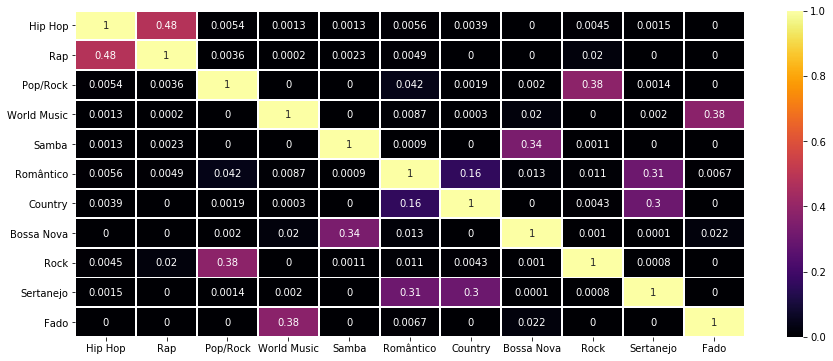

In [37]:

fig, ax = plt.subplots(figsize=(15,6))   
sns.heatmap(df.round(4), cmap = 'inferno', annot=True, linewidth = 1)
plt.show()

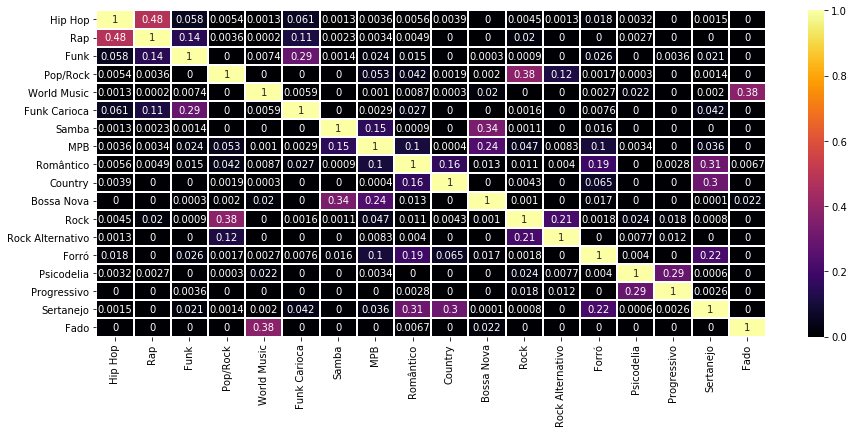

In [35]:

fig, ax = plt.subplots(figsize=(15,6))   
sns.heatmap(df.round(4), cmap = 'inferno', annot=True, linewidth = 1)
plt.show()

In [33]:
def process(genres_arr):
    size = 0
    try:
        size = len(genres_arr)
    finally:
        return size
       
    
df_lyrics["SizeGenres"] = df_lyrics["Genres"].map(process)


In [34]:
df_lyrics["SizeGenres"].value_counts()

3    190499
2     14553
1      9995
Name: SizeGenres, dtype: int64

In [35]:
df_lyrics[df_lyrics["SizeGenres"]==1]

,ALink,SName,SLink,Lyric,ParentGenre,Genres,SizeGenres
312,/laura-helena/,Agora sai,/laura-helena/agora-sai.html,Não queria ter feito o que eu fiz. pois bem. F...,Black Music,[Black Music],1
313,/laura-helena/,Essa sou eu,/laura-helena/essa-sou-eu.html,Eu sempre fui assim. quis me esconder. Com med...,Black Music,[Black Music],1
314,/laura-helena/,Fazer voce acreditar,/laura-helena/fazer-voce-acreditar.html,Agora. é a hora. não tenho nada a perder. mas ...,Black Music,[Black Music],1
315,/laura-helena/,Me Encontrar,/laura-helena/me-encontrar.html,Whoa. Oh. Ooh. . Nesta festa. Sozinha começo a...,Black Music,[Black Music],1
316,/laura-helena/,Nunca Vou Te Esquecer (Dueto),/laura-helena/nunca-vou-te-esquecer.html,Ela:parece que ele não me ajuda. Que ele não m...,Black Music,[Black Music],1
317,/laura-helena/,Pensar Alto,/laura-helena/pensar-alto.html,Olhe para essa noite. De lua cheia. Olhe para ...,Black Music,[Black Music],1
318,/laura-helena/,Se desligue do mundo,/laura-helena/se-desligue-do-mundo.html,Vai lá. respire fundo. e se desligue do mundo....,Black Music,[Black Music],1
319,/laura-helena/,Sozinha,/laura-helena/sozinha.html,Foi íncrivel. foi um sonho sim. Todas as lembr...,Black Music,[Black Music],1
322,/leandro-luther-fumaca/,Estilosa,/leandro-luther-fumaca/estilosa.html,Êta lá em casa!. Lá no meu barraco!. Ia ser um...,Black Music,[Black Music],1
1986,/andre-christovam/,Carne de Pescoço,/andre-christovam/carne-de-pescoco.html,"Em plena rua Aurora, meu carro pifou. Chegando...",Blues,[Blues],1


In [36]:
df_2 = df_lyrics[df_lyrics["SizeGenres"]==1]
df_2["ParentGenre"].value_counts()

Sertanejo           2307
Gospel/Religioso    2089
MPB                  779
Funk Carioca         652
Forró                606
Rap                  522
Pop/Rock             365
Pop                  342
Samba                302
Reggae               263
World Music          193
Infantil             180
Samba Enredo         173
Rock                 162
Bossa Nova           150
Pagode               130
Heavy Metal          111
Folk                 104
Punk Rock             95
Trilha Sonora         80
Hip Hop               75
Hardcore              53
Hard Rock             36
Fado                  35
Indie                 31
Regional              22
New Age               17
Kizomba               16
Blues                 15
Dance                 12
Romântico             11
Country               10
Electronica            9
Black Music            9
Metal                  9
J-Pop/J-Rock           8
Funk                   6
R&B                    5
Jovem Guarda           3
Instrumental           2
